In [87]:
%matplotlib inline

import os
import json
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

HTML_TEMPLATE = './report_template.html'
IDEALS_FILENAME = './ideal_mix.json'
BAD_DATA = ['SUDU-2013']

def get_deduped_plants(yearsite_df):
    
    deduped_plants = []
    
    samples = yearsite_df[['Transect','Point','Species']].groupby(['Transect','Point'])
    sample_indices = samples.groups
    raw_species = yearsite_df['Species']
    
    for group in sample_indices.keys():
        group_observations = raw_species.loc[sample_indices[group]]
        group_species = group_observations.unique()
        deduped_plants = deduped_plants + list(group_species)
     
    
    return pd.Series(deduped_plants)


def calculate_observed_proportions(yearsite_df):

    deduped_plants = get_deduped_plants(yearsite_df)
    deduped_counts = deduped_plants.value_counts()
    observed_proportions = deduped_counts/deduped_counts.sum()
    
    return observed_proportions

# def get_observed_species_set(yearsite_df):
    
#     observed_species = yearsite_df['Species']
#     unique_observed_species = set(observed_species.unique())

#     return yearsite_df


def df_from_landsend_data():
    df = pd.read_csv('./landsend_veg_2007_2012.csv')
    
    df['Site'] = df['Site-YearCode'].apply(lambda x: x.split('-')[0])
    df['Year'] = df['Site-YearCode'].apply(lambda x: int(x.split('-')[1]))
    return df

def ideals_from_json(filename=IDEALS_FILENAME):
    with open(filename,'r') as infile:
        ideal_mix = json.load(infile)

    return sorted(ideal_mix.items(), key=lambda x: x[1])


In [85]:
def create_linklist(yearsite, collection_sets):
    
    linklist = ''
    
    linkstring = "<span><a href='./%s'>%s</a></span>\n"
    placeholder = "<span>%s</span>\n"
    
    for ys in sorted(collection_sets):
        if not ys == yearsite:
            linklist += linkstring % (pagename(ys),ys)
        else:
            linklist += placeholder % yearsite
    
    return linklist
    
def pagename(yearsite):
    return '%s_report.html' % (yearsite.lower())
    
def write_report_page(table_text, yearsite, collection_sets, template=HTML_TEMPLATE):
    
    link_list = create_linklist(yearsite, collection_sets)
    
    with open(template,'r') as infile:
        html = infile.read()
        
    html = html.replace('{{ yearsite }}', yearsite)
    html = html.replace('{{ table }}', table_text)
    html = html.replace('{{ page_links }}', link_list)

    assert os.path.isdir('./reports'), \
        'No reports directory! Everything is gone to hell, probably.'
        
    savepath = os.path.join('.','reports',pagename(yearsite))
    
    with open(savepath, 'w') as htmlfile:
        htmlfile.write(html)

In [79]:
def plot_ideal_observed(observed_proportions,ideal_proportions,yearsite):
    
    n_groups = len(ideal_proportions)
    species,ideals = zip(*ideal_proportions)

    observed_desired = observed_proportions[list(species)].fillna(0.0005)

    fig, ax = plt.subplots(figsize=(11.5,9.5))

    index = np.arange(1,n_groups+1)
    bar_width = 0.35
    opacity = 0.4

    rects1 = plt.barh(index - bar_width, ideals, bar_width,
                     alpha=opacity,
                     color='b',
                     label='Ideal')
    rects2 = plt.barh(index, observed_desired, bar_width,
                     alpha=opacity,
                     color='r',
                     label=yearsite)

    plt.ylabel('Species',fontsize=18)
    plt.xlabel('Proportion', fontsize=18)
    plt.xlim(0,.26)
    
    plot_title = 'Ideal and Observed Scrub Mix for %s' % yearsite
    #plt.title(plot_title, fontsize=18)
    
    ax.set_yticks(index)
    ax.set_yticklabels(species, fontsize=16)
    plt.legend(fontsize=14,loc='lower right')
    
    
    if not os.path.isdir('./reports'):
        os.mkdir('./reports')
    if not os.path.isdir('./reports/img'):
        os.mkdir('./reports/img')
    savename = 'ideal_observed_plot_%s.png' % yearsite
    savepath = os.path.join('.','reports','img',savename)
    
    
    plt.savefig(savepath, bbox_inches='tight')

In [59]:
def filter_out_ideals(observed_proportions,ideal_proportions):
   
    observed_species_set = set(observed_proportions.keys())
    ideal_species = set(dict(ideal_proportions).keys())
    
    extra_species = observed_species_set.difference(ideal_species)
    extra_species = list(extra_species)
    
    filtered_observations = observed_proportions[extra_species]
    filtered_observations.sort_values(ascending=False, inplace=True)
    
    return pd.DataFrame(filtered_observations)

    
def create_table(observed_proportions,ideal_proportions,yearsite):

    table_df = filter_out_ideals(observed_proportions, ideal_proportions)
    
    pct_fmt = lambda x:  '%0.2f%%' % (x*100)
    
    table_out = table_df.to_html(header=False, 
                                 bold_rows=False, 
                                 formatters={0:pct_fmt}
                                )
    _, table_text = table_out.split('<tbody>')
    
    return table_text



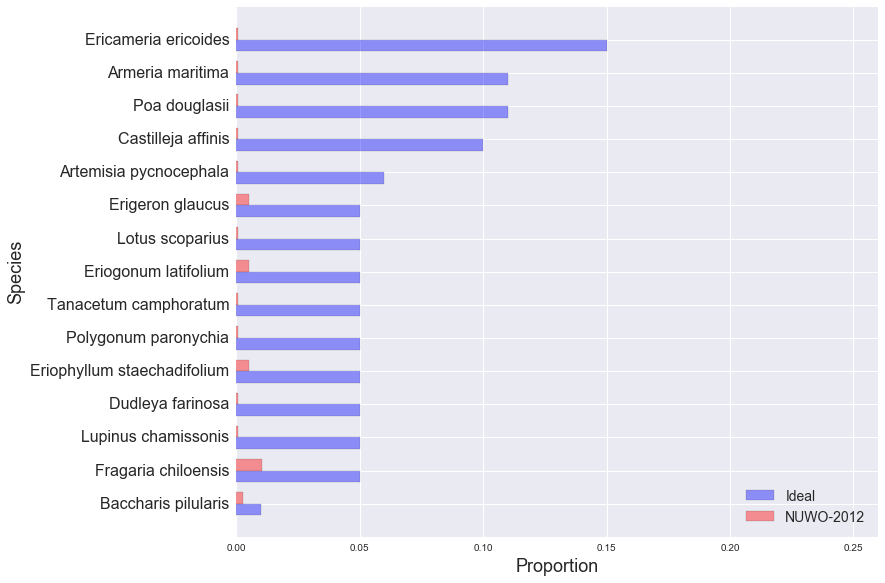

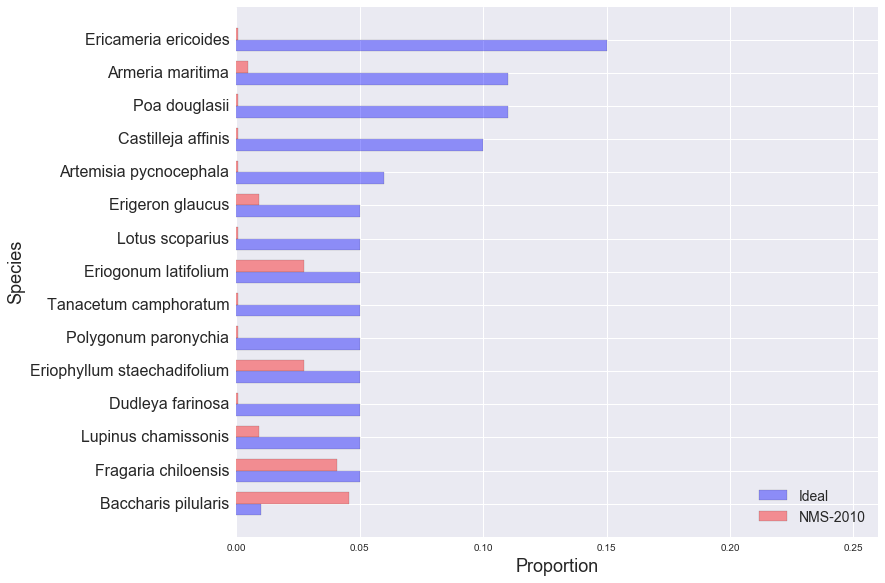

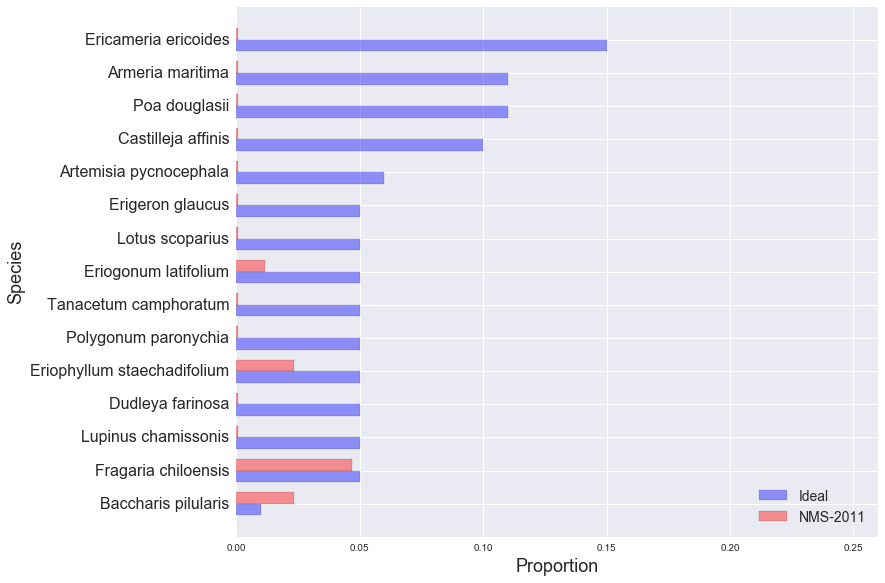

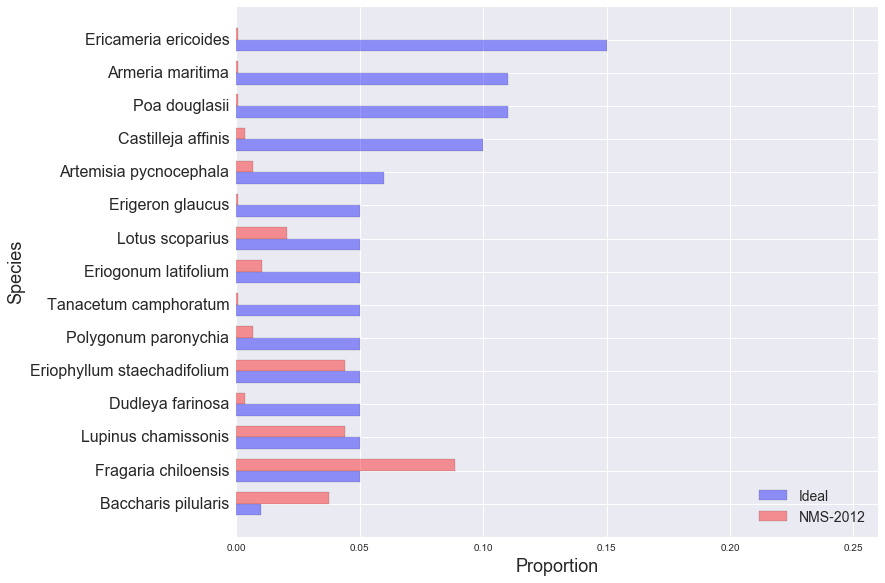

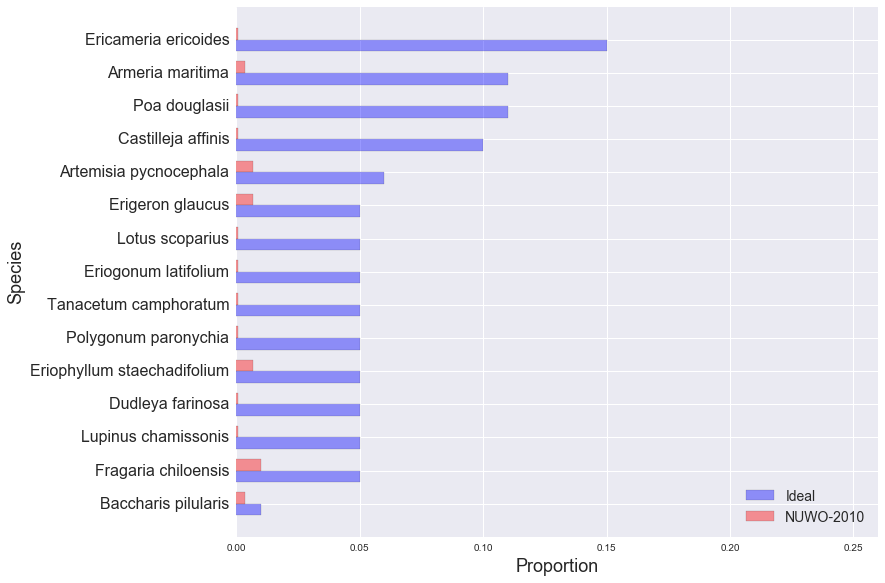

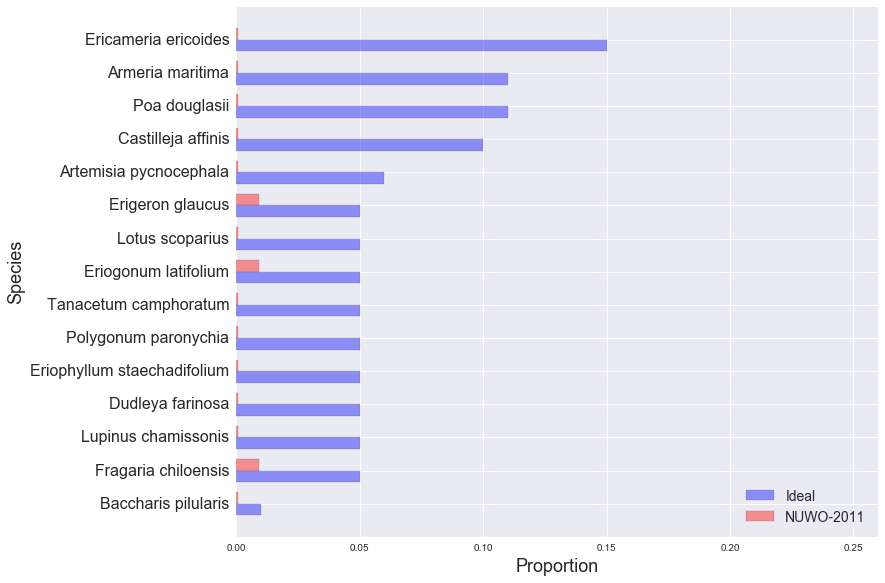

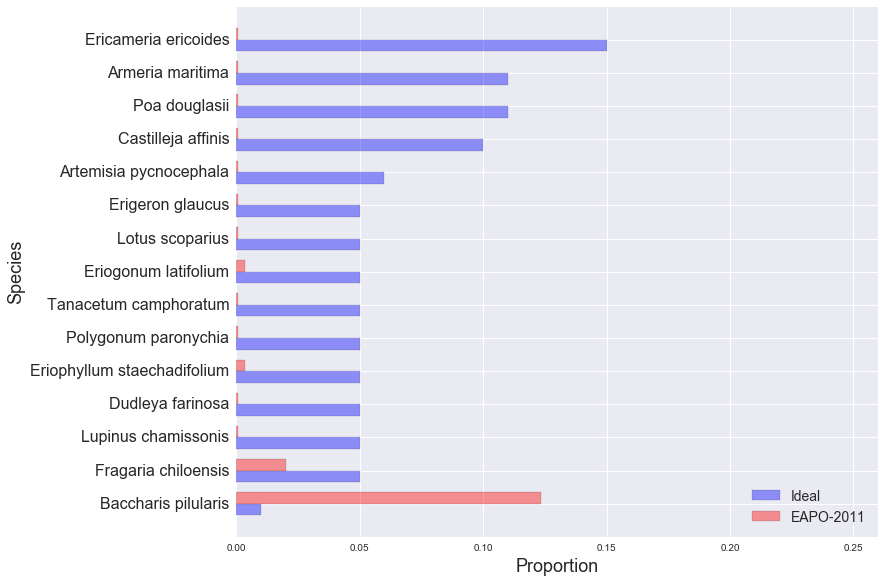

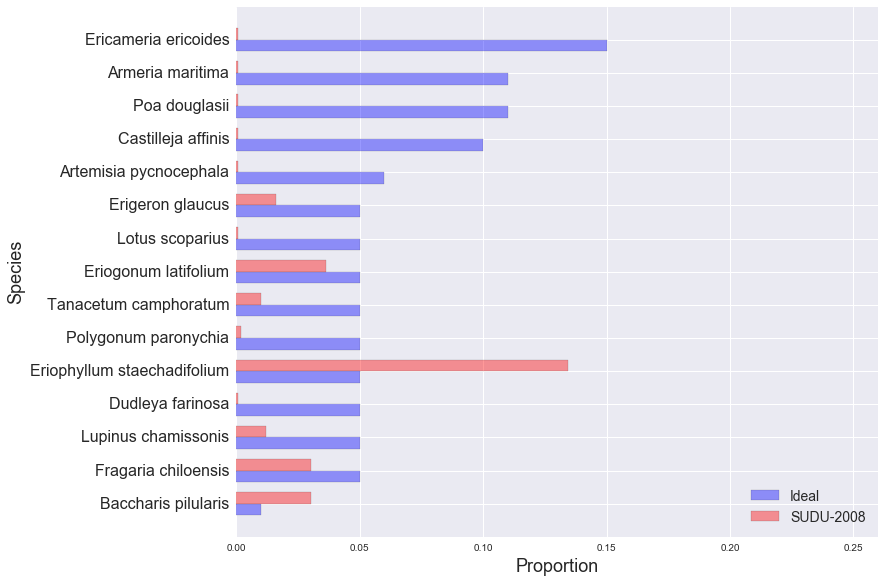

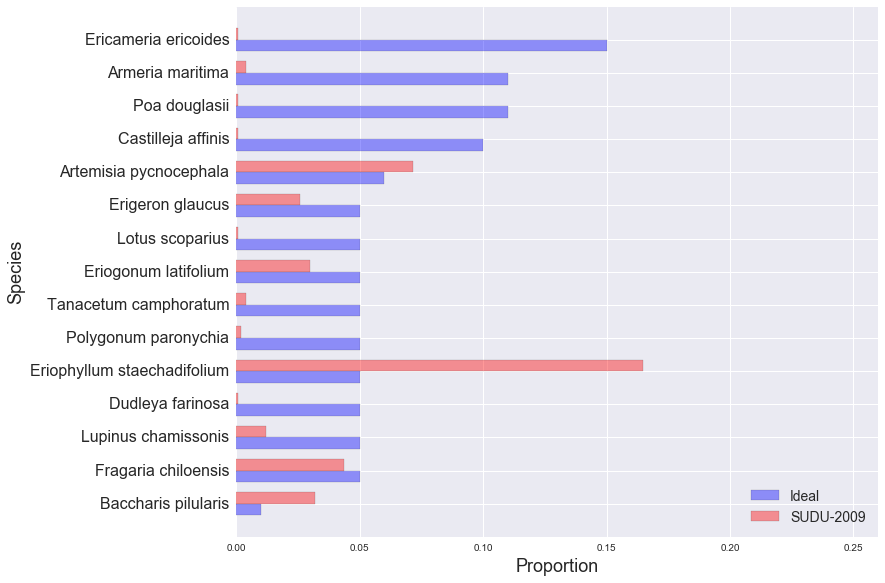

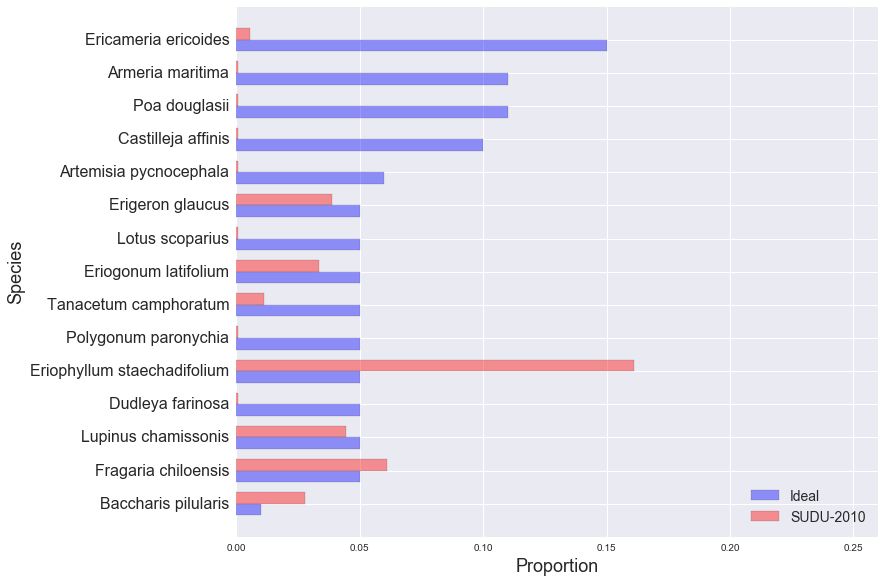

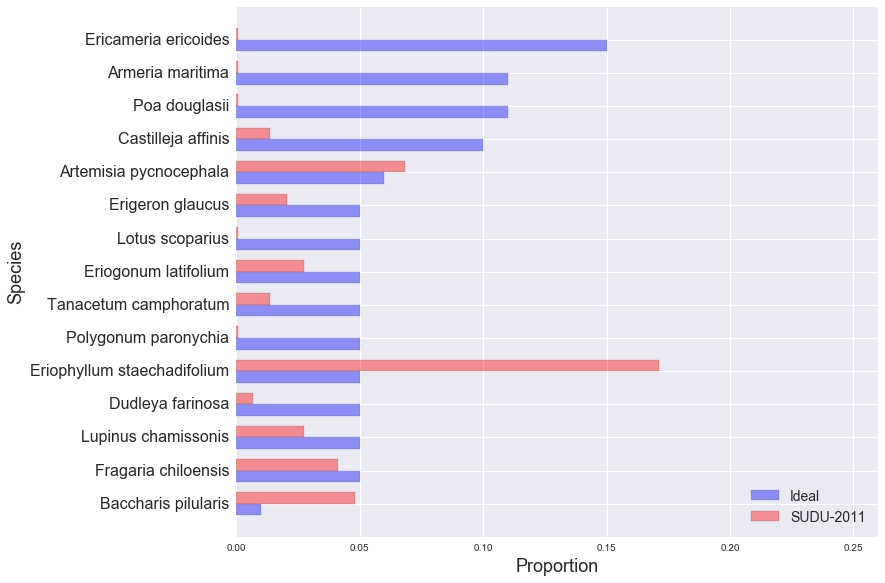

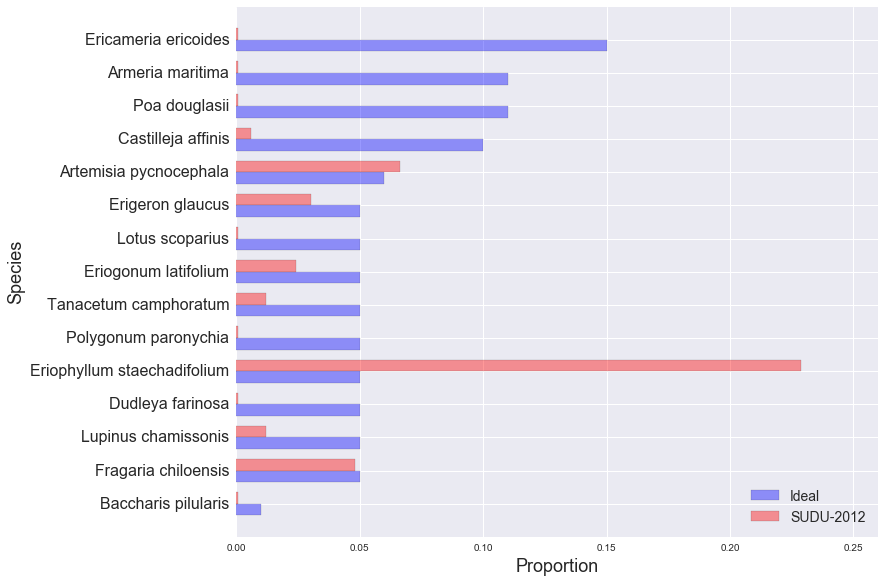

In [97]:
def main():

    df = df_from_landsend_data()
    ideal_proportions = ideals_from_json()

    collection_sets = df['Site-YearCode'].unique()
    collection_sets = [cs for cs in collection_sets if cs not in BAD_DATA]
    
    for yearsite in collection_sets:
        
        ysdf = df[df['Site-YearCode'] == yearsite]
 
        observed_proportions = calculate_observed_proportions(ysdf)
        
        plot_ideal_observed(observed_proportions, ideal_proportions, yearsite)
        
        table_text = create_table(observed_proportions,ideal_proportions,yearsite)
        write_report_page(table_text, yearsite, collection_sets)
        
main()